# <u>Behavioral Metrics:</u>

## **1. Introduction**
[back to top](#scrollTo=bvONhqQblFfl&uniqifier=1)

Welcome to the last week of the course -- so excited to see that you've made it to the end! 👏 

We've already discussed the importance of measuring model performance. As Lord Kelvin said, "To measure is to know – If you cannot measure it, you cannot improve it." And he was right – metrics are the only way we can actually evaluate our model’s performance!

In this week's project, we will touch upon two key aspects related to evaluation:
1. Behavioral metrics: We will work with a Spotify music sessions dataset and implement a few behavioral metrics to understand their relationships with traditional metrics.
2. Off-policy evaluation: We will simulate a dataset where we have logged action policies, and see how IPS is implemented.
  
<br>

### About the Data: Spotify Music Sessions
Behavioral metrics include factors like what items a user interacts with and how, the amount of time they spend on the platform, and how they spend that time. To define and implement a few behavioral metrics, we will work with the Spotify music sessions dataset.

The public part of the dataset consists of roughly 130 million listening sessions with associated user interactions on the Spotify service. In total, users interacted with almost 4 million tracks during these sessions, and the dataset includes acoustic features and metadata for all of these tracks. We'll be working with a sample of the full dataset.
  
<br>A detailed description of the dataset can be found [here](https://drive.google.com/file/d/1BELTuH4nBeyHna5EAGzJv-HWHKrbxPsf/view?usp=sharing).


## **2. Setup**
[back to top](#scrollTo=bvONhqQblFfl&uniqifier=1)

In [1]:
# Imports
import numpy as np
import pandas as pd
from sklearn.metrics import ndcg_score
from collections import OrderedDict
from IPython.display import clear_output
from functools import partial
from tqdm import tqdm
tqdm.pandas()


# Download the data
!pip install -U --no-cache-dir gdown --pre
!gdown --no-cookies --fuzzy https://drive.google.com/file/d/1Z8N0Xf9M34PuN4V5G5uAxasvOCm6TVp4/view?usp=sharing
!gdown --no-cookies --fuzzy https://drive.google.com/file/d/1D3RyRBKBaw0KbLxpJUQDjVIt5CLpE2n9/view?usp=sharing

clear_output()

In [32]:
# Read in data
log = pd.read_csv("log_mini.csv")
tracks = pd.read_csv("tf_mini.csv")

log.shape, tracks.shape

((167880, 21), (50704, 30))

## **3. Traditional metrics: NDCG@K**
[back to top](#scrollTo=bvONhqQblFfl&uniqifier=1)

Normalized Discounted Cumulative Gain (NDCG) is a metric used to evaluate a ranked list of candidates, which values both order and relevancy of the items. In other words, it is able to use the fact that some documents are "more" relevant than others. Highly relevant items should come before medium relevant items, which should come before non-relevant items.
  
<br>We will use the log dataframe as the main dataframe for evaluation of metrics. The `skip_1` flag can be used as a relevance signal -- if the user found the recommendation relevant, `skip_1 = False`. With this relevance signal, we can compute simple NDCG metrics -- one for each session and then averaged across all sessions. This will serve as a base metric for comparison.

Note: the ranking logic here is assumed to be the production ranker, i.e. sorting by `session_position` gives the exact order of tracks the Spotify ranker presented to the user.
  
<br>Let's compute a simple skip rate and NDCG metric for the production ranker:

In [3]:
# Compute average skip rate @ 10

topk = 10
log.sort_values(by=['session_position']).groupby("session_id").apply(lambda x: np.mean(x['skip_1'].values[:topk])).mean()

0.40894

In [4]:
# Compute NDCG @ 10

def compute_ndcg(df, topk):
    df = df.iloc[:topk]
    true_relevance = np.asarray(1-np.asarray(df['skip_1']*1.0))
    ranker_scores = np.asarray(1/(np.asarray(range(len(df)))+1)) # Approximate the ranker scores using the session position
    return ndcg_score([true_relevance], [ranker_scores])

topk = 10
log.sort_values(by=['session_position']).groupby("session_id").progress_apply(partial(compute_ndcg, topk=topk)).mean()

100%|██████████| 10000/10000 [00:20<00:00, 487.35it/s]


0.8330266041453142

## **4. TODO 4.1: Implement 3 Behavioral Metrics**
[back to top](#scrollTo=bvONhqQblFfl&uniqifier=1)

Your first goal is to implement three behavioral metrics and compare their correlations:
1. *Time to first skip:* How long did it take for the user to get the first bad recommendation, i.e. a recommendation they skipped. Since we can't easily calculate time, we can use number of songs as a proxy and compute the metric as number of songs it took for the first skip.

2. *Sustained dissatisfaction:* We assume that the user is dissatisfied in a sustained manner if they skip 3 songs consecutively.

3. *Session coherence:* We define coherence as how similar the recommended musical tracks are. We can use the acoustic_vector of the music tracks to calculate the similarity.

Once these metrics are implemented, compute them for `topk=5` and `topk=10`. Compare their estimates for the production ranker as a correlation plot. Please note which metrics are correlated with NDCG.

In [5]:
# Implement session metric 1:
    # Time to first skip (number of songs to first skip)
    # Our implementation found the answer to be 4.6380
        # We assumed no skips yields the number of songs listened to as opposed to a null

def find_first_skip(skip_list):
  """
  Finds the index of the first skip in a list of skip_1 values. 
  If all values are False, return the length of the array.
  """
  true_indices = np.where(skip_list)
  if len(true_indices[0]) == 0:
    return len(skip_list) 
  else:
    return true_indices[0][0] + 1

print(f"Time to first skip: {log.sort_values(by=['session_position']).groupby('session_id').apply(lambda x: find_first_skip(x['skip_1'].values)).mean()}")

for topk in [5, 10]:
  print(f"Top k @ {topk}: {log.sort_values(by=['session_position']).groupby('session_id').apply(lambda x: find_first_skip(x['skip_1'].values[:topk])).mean()}")

Time to first skip: 4.6348
Top k @ 5: 3.0775
Top k @ 10: 4.0886


In [6]:
# Implement session metric 2:
    # Sustained dissatisfaction: Proportions of sessions with 3 consecutive skips
    # Our implementation found the answer to be 0.6543

def has_three_skips(skip_list):
  """
  Returns 1 if skip_list has three consecutive skips and 0 otherwise.
  """
  for i in range(len(skip_list)-2):
    if sum(skip_list[i:i+3]) == 3:
      return 1
  return 0

print(f"Proportion of sessions with 3 consecutive skips: {log.sort_values(by=['session_position']).groupby('session_id').apply(lambda x: has_three_skips(x['skip_1'].values)).mean()}")

for topk in [5, 10]:
  print(f"Top k @ {topk}: {log.sort_values(by=['session_position']).groupby('session_id').apply(lambda x: has_three_skips(x['skip_1'].values[:topk])).mean()}")    

Proportion of sessions with 3 consecutive skips: 0.6543
Top k @ 5: 0.2964
Top k @ 10: 0.5238


In [7]:
from sklearn.metrics.pairwise import cosine_similarity
# Implement session metric 3: 
    # Session coherence: Average similarity between the top recommended tracks
    # Our implementation found the answer to be ~0.8097
        # We calculated the Cosine Similarity between tracks using the 8 element acoustic vector per track
        # Cosine Similarity is the dot product of unit-length vectors
        # Feel free to use a different similarity metric, such as Euclidean Distance from last week

def compute_avg_similarity(track_id_list):
  """
  Takes in a list of track IDs and returns the average similarity between the tracks
  """
  track_vectors = tracks[tracks['track_id'].isin(track_id_list)][
    ['acoustic_vector_0', 
     'acoustic_vector_1', 
     'acoustic_vector_2',
     'acoustic_vector_3', 
     'acoustic_vector_4', 
     'acoustic_vector_5',
     'acoustic_vector_6', 
     'acoustic_vector_7'
     ]
  ]

  return cosine_similarity(track_vectors).mean()

print(f"Average similarity: {log.sort_values(by=['session_position']).groupby('session_id').apply(lambda x: compute_avg_similarity(x['track_id_clean'].values)).mean()}")

for topk in [5, 10]:
  print(f"Top k @ {topk}: {log.sort_values(by=['session_position']).groupby('session_id').apply(lambda x: compute_avg_similarity(x['track_id_clean'].values[:topk])).mean()}")   


Average similarity: 0.8190426042511496
Top k @ 5: 0.8569095224919191
Top k @ 10: 0.8332746661515774


In [23]:
topk = 5
df = pd.DataFrame({
      f"ndcg_topk@{topk}": log.sort_values(by=['session_position']).groupby("session_id").progress_apply(partial(compute_ndcg, topk=topk)),
      f"first_skip@{topk}": log.sort_values(by=['session_position']).groupby('session_id').progress_apply(lambda x: find_first_skip(x['skip_1'].values[:topk])),
      f"sustained_dissatisfaction@{topk}": log.sort_values(by=['session_position']).groupby('session_id').progress_apply(lambda x: has_three_skips(x['skip_1'].values[:topk])),
      f"session_coherence@{topk}": log.sort_values(by=['session_position']).groupby('session_id').progress_apply(lambda x: compute_avg_similarity(x['track_id_clean'].values[:topk])),
  })

100%|██████████| 10000/10000 [00:54<00:00, 182.43it/s]


<AxesSubplot:>

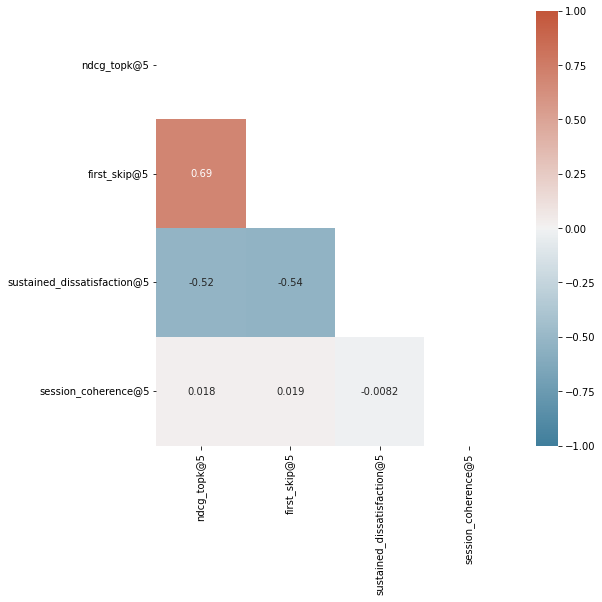

In [28]:
# Correlation plot amongst metrics and NDCG
import seaborn as sns
import matplotlib.pyplot as plt

# correlation plot for topk = 5

plt.figure(figsize=(8,8))
corr=df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, annot=True)



## **5. TODO 4.2: Implement a New, Non-Learnt Ranker**
[back to top](#scrollTo=bvONhqQblFfl&uniqifier=1)

Your next goal is to implement another simple, non-learnt ranking logic, and compare the performance of both the production ranker and new ranking policy on the NDCG and three behavioral metrics you created above. A simple ranking policy could include sort by track popularity, or sort by danceability score for the track.
  
<br>Implement your ranker and then comment on its performance on our behavioral metrics compared to Spotify's production ranker:

In [63]:
log = pd.read_csv("log_mini.csv")

In [64]:
log = pd.merge(log, tracks[['track_id', 'release_year', 'us_popularity_estimate', 'energy', 'beat_strength']], left_on='track_id_clean', right_on='track_id', how='left')

log['new_rank_popularity_rank'] = log.groupby('session_id')['us_popularity_estimate'].rank(ascending=False)
log['release_year_rank'] = log.groupby('session_id')['release_year'].rank(ascending=False)
log['beat_strength'] = log.groupby('session_id')['beat_strength'].rank(ascending=False)
log['energy'] = log.groupby('session_id')['energy'].rank(ascending=False)
log['new_rank_score'] = (log.new_rank_popularity_rank+log.energy+log.beat_strength+log.release_year_rank)/4
log['new_rank'] = log.new_rank_score.rank(ascending=False)

In [66]:
print(f"ndcg_topk@{topk} for production ranker: {log.sort_values(by=['session_position']).groupby('session_id').progress_apply(partial(compute_ndcg, topk=topk)).mean()}")
print(f"ndcg_topk@{topk} for new ranker: {log.sort_values(by=['new_rank']).groupby('session_id').progress_apply(partial(compute_ndcg, topk=topk)).mean()}")
print(f"first_skip@{topk} for production ranker: {log.sort_values(by=['session_position']).groupby('session_id').progress_apply(lambda x: find_first_skip(x['skip_1'].values[:topk])).mean()}")
print(f"first_skip@{topk} for new ranker: {log.sort_values(by=['new_rank']).groupby('session_id').progress_apply(lambda x: find_first_skip(x['skip_1'].values[:topk])).mean()}")
print(f"session_coherence@{topk} for production ranker: {log.sort_values(by=['session_position']).groupby('session_id').progress_apply(lambda x: compute_avg_similarity(x['track_id_clean'].values[:topk])).mean()}")
print(f"session_coherence@{topk} for new ranker: {log.sort_values(by=['new_rank']).groupby('session_id').progress_apply(lambda x: compute_avg_similarity(x['track_id_clean'].values[:topk])).mean()}")

100%|██████████| 10000/10000 [00:17<00:00, 564.18it/s]


ndcg_topk@5 for production ranker: 0.8235700606177565


100%|██████████| 10000/10000 [00:12<00:00, 774.45it/s]


ndcg_topk@5 for new ranker: 0.7535962241368467


100%|██████████| 10000/10000 [00:00<00:00, 14731.70it/s]


first_skip@5 for production ranker: 3.0775


100%|██████████| 10000/10000 [00:00<00:00, 17794.28it/s]


first_skip@5 for new ranker: 2.501


100%|██████████| 10000/10000 [00:58<00:00, 172.11it/s]


session_coherence@5 for production ranker: 0.8569095224919191


100%|██████████| 10000/10000 [00:53<00:00, 185.41it/s]

session_coherence@5 for new ranker: 0.8317141052954461


In [ ]:
# Comments on performance
"""
I tried a handful of different features to use for ranking and different methods of combining the rank scores but none of them could beat the production ranker!
"""

# <u>Off-Policy Evaluation:</u>

## **1. Introduction**
[back to top](#scrollTo=bvONhqQblFfl&uniqifier=1)

We log listener behavior based on the recommendations that the production recommender serves to the listener. Using this data to assess any new recommender system, however, can present challenges – the production recommender and the new recommender can drastically differ in the results that they display to the user. For example, maybe the new recommender presents a lot of niche content, while the production recommender presents a lot of popular options. This can be an issue when evaluating a new recommender – If you don’t have any feedback on a recommendation because you never presented it to a user, how can you evaluate whether it’s a good recommendation?
If you have a new policy to test that’s very similar to your old approach, then this won’t be an issue, and it’ll be easy to test! However, if the policy is very different, then you’ll need to collect special logged data.

In this part of the project, we will simulate a recommendation policy and leverage counterfactual estimators as metrics to compare performance.

## **2. Setup**
[back to top](#scrollTo=bvONhqQblFfl&uniqifier=1)

Let's first begin by generating a few users and products. For ease of simulation, we assume users derive equal satisfaction from each item:

In [68]:
users = np.array(["user1", "user2", "user3"])

products = np.array(
    [
        "product_a",
        "product_b",
        "product_c",
        "product_d",
        "product_e",
        "product_f",
        "product_g",
    ]
)

satisfaction = {
    "product_a": 100,
    "product_b": 150,
    "product_c": 100,
    "product_d": 200,
    "product_e": 500,
    "product_f": 120,
    "product_g": 160,
}

Let's also implement whether a given user will accept a given recommendation or not. Once done, we can implement a target policy that makes recommendations.

In [69]:
def will_purchase(user, product):
    if user == "user1" and (
        product == "product_a" or product == "product_b" or product == "product_c"
    ):
        return True
    elif user == "user2" and (product == "product_d" or product == "product_e"):
        return True
    elif user == "user3" and (product == "product_f" or product == "product_g"):
        return True
    else:
        return False


def choose_user():
    return np.random.choice(users, size=1)


def logging_policy():
    return np.random.choice(products, size=1), 1 / len(products)


class TargetPolicy:
    def __init__(self):
        self.user_probs = {
            "user1": np.array([0.1, 0.1, 0.2, 0.1, 0.15, 0.15, 0.20]),
            "user2": np.array([0.1, 0.10, 0.05, 0.25, 0.3, 0.1, 0.1]),
            "user3": np.array([0.06, 0.06, 0.3, 0.06, 0.06, 0.4, 0.06]),
        }

        for user, probs in self.user_probs.items():
            assert probs.sum() == 1
            assert len(probs) == len(products)

    def recommend(self, user):
        user_prob = self.user_probs[user]
        product = np.random.choice(products, size=1, p=user_prob)
        product_idx = np.where(products == product)
        prob = user_prob[product_idx]

        return product, prob

    def get_prob(self, user, product):
        user_prob = self.user_probs[user]
        product_idx = np.where(products == product)
        product_prob = user_prob[product_idx]

        return product_prob

Having defined all key components of the dataset generation, let's create logged data that we can finally use for evaluation purposes:

In [70]:
def compute_satisfaction(user, product):
    if will_purchase(user, product):
        return satisfaction[product.item()]
    else:
        return 0


def create_logs(n=1000):
    logs = []
    target_policy = TargetPolicy()

    for _ in tqdm(range(n)):
        user = choose_user()

        logging_product, logging_prob = logging_policy()
        model_prob = target_policy.get_prob(user.item(), logging_product)

        target_product, _ = target_policy.recommend(user.item())

        logging_satisfaction = compute_satisfaction(user, logging_product)
        target_satisfaction = compute_satisfaction(user, target_product)

        log = OrderedDict(
            {
                "user_features": user.item(),
                "item_placed": logging_product.item(),
                "item_prob": logging_prob,
                "item_satisfaction": logging_satisfaction,
                "model_prob": model_prob.item(),
                "ab_test_satisfaction": target_satisfaction,
            }
        )

        logs.append(log)

    return pd.DataFrame(logs)

Here is what our logged data now looks like:

In [71]:
logs = create_logs(n=1000)
logs.head(5)

100%|██████████| 1000/1000 [00:00<00:00, 7804.01it/s]


,user_features,item_placed,item_prob,item_satisfaction,model_prob,ab_test_satisfaction
0,user3,product_e,0.142857,0,0.06,0
1,user1,product_f,0.142857,0,0.15,0
2,user2,product_g,0.142857,0,0.10,200
3,user3,product_a,0.142857,0,0.06,0
4,user2,product_f,0.142857,0,0.10,200


## **3. Rewards and IPS**
[back to top](#scrollTo=bvONhqQblFfl&uniqifier=1)

With the dataset ready, let's compute the mean rewards (satisfaction) for the logging/production policy and the target policy. Note that due to randomness in the log generation process your result will likely differ.


In [72]:
sim = create_logs(n=100_000)
logging_policy_reward = sim["item_satisfaction"].mean()
target_policy_reward = sim["ab_test_satisfaction"].mean()

print(f"Expected reward from logging policy: {logging_policy_reward:.2f}")
print(f"Expected reward from target policy: {target_policy_reward:.2f}")

100%|██████████| 100000/100000 [00:14<00:00, 6969.40it/s]


Expected reward from logging policy: 63.70
Expected reward from target policy: 101.07


Now let's implement the IPS estimator:

In [73]:
def compute_ips(df):
    assert {"model_prob", "item_prob", "item_satisfaction"}.issubset(df.columns)
    return (df["model_prob"] / df["item_prob"] * df["item_satisfaction"]).mean()

compute_ips(logs)

104.61779999999999

Computing the IPS estimator on our 1,000 entry log gives an average revenue much closer to our expected reward from the target policy compared to that of the logging policy. Therefore, we should be confident to deploy our target policy to production and do an A/B test comparing it with the logging policy as a final validation.

## **4. TODO 4.3: Capped IPS and NCIS**
[back to top](#scrollTo=bvONhqQblFfl&uniqifier=1)

Your goal is to implement two additional off-policy estimators:
1. Capped IPS
2. Normalized Capped Importance Sampling (NCIS)

Feel free to try different capping thresholds, and compare the reward and standard deviations of these estimators with the IPS estimator and mean reward.

In [86]:
def compute_capped_ips(logs, cap=1000):
    """
    Computes the Capped IPS.

    Args:
        logs (DataFrame): Generated logs data
        cap (int): Capping threshold

    Returns:
        ips (float): Resulting IPS
    """
    ips = 0

    # Your code goes here
    ips = (np.minimum(logs["model_prob"] / logs["item_prob"], cap)* logs["item_satisfaction"]).mean()

    return ips

In [87]:
compute_capped_ips(logs)

104.61779999999999

In [92]:
def compute_ncis(logs, cap=1000):
    """
    Computes the NCIS.

    Args:
        logs (DataFrame): Generated logs data
        cap (int): Capping threshold

    Returns:
        ncis (float): Resulting NCIS
    """
    ncis = 0

    # Your code goes here
    ncis = compute_capped_ips(logs, cap) / (logs["model_prob"] / logs["item_prob"]).mean()

    return ncis

In [93]:
compute_ncis(logs)

107.05107084019768